In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from IPython.display import HTML
import matplotlib.patheffects as pe

# Set visual style for scientific validation
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)

In [76]:
# Load Master Data
INPUT_FILE = '../data/processed/tracking_clean_normalized.csv'
df = pd.read_csv(INPUT_FILE, low_memory=False)

In [ ]:
# 1. Check Line of Scrimmage (LOS) Distribution
# It should be distributed between ~10 and ~110 (not 0 or 120)
print("LOS Stats:")
print(df['los_x'].describe())

# 2. Check "Depth" (Player X relative to LOS)
# Since we normalized offense Left-to-Right:
# Defenders should mostly be at X > LOS (Positive Depth)
# Offense (QB) should be at X < LOS (Negative Depth)
df['depth_check'] = df['x'] - df['los_x']

print("\nAverage Depth by Position (Expect (+) for CB/S/LB, (-) for QB):")
print(df.groupby('player_position')['depth_check'].mean().sort_values())

# 3. Check Pass Length (Ball Land X relative to LOS)
# Most passes are forward, so Ball Land X > LOS (Positive Result)
df['pass_length_check'] = df['ball_land_x'] - df['los_x']

print("\nPass Length Stats (Should be mostly positive):")
print(df['pass_length_check'].describe())

# 4. Check negative pass lengths (Screens/Dump-offs)
neg_passes = (df['pass_length_check'] < 0).mean()
print(f"\n% of Passes landing behind LOS: {neg_passes:.2%}")
# If this is > 20%, we might have a normalization flip error.

In [ ]:
# 1. Inspect Event Tags in Post-Throw Phase
print("--- POST-THROW EVENT ANALYSIS ---")
post_throw_df = df[df['phase'] == 'post_throw']
print(post_throw_df.head(5))
# What events exist in this phase?
print("Unique Events found in Post-Throw:")
print(post_throw_df['event'].unique())

# 2. Check for "Run After Catch"
# Let's pick a specific play that was a completion ('C') and see if frames continue after the catch event.
completed_plays = df[df['pass_result'] == 'C']
sample_play_id = completed_plays['play_id'].iloc[0]
sample_game_id = completed_plays['game_id'].iloc[0]

sample_play = df[(df['game_id'] == sample_game_id) & (df['play_id'] == sample_play_id)]

print(f"\n--- FRAME ANALYSIS FOR PLAY {sample_play_id} (COMPLETED) ---")
print(sample_play[['frame_id', 'phase', 'event']].drop_duplicates().sort_values('frame_id'))

# 3. Frequency of Catch Events
# How often do we see specific "End of Play" tags?
print("\n--- EVENT FREQUENCY ---")
print(post_throw_df['event'].value_counts())

In [77]:
def diagnose_data_gaps(df, name="DataFrame"):
    """
    Forensic analysis of Missing Values (NaNs).
    """
    print(f"\n{'='*60}")
    print(f"🕵️‍♀️ DATA FORENSICS: {name}")
    print(f"{'='*60}")
    print(f"Total Rows: {len(df):,}")
    
    # 1. IDENTIFY MISSING COLUMNS
    # Get columns that have ANY nulls
    null_counts = df.isna().sum()
    null_cols = null_counts[null_counts > 0]
    
    if null_cols.empty:
        print("✅ CLEAN. No missing values found in any column.")
        return
    
    # 2. REPORT METRICS
    print(f"\n⚠️ FOUND GAPS IN {len(null_cols)} COLUMNS:")
    print(f"{'-'*60}")
    print(f"{'Column Name':<25} | {'Missing Count':<15} | {'% Missing':<10}")
    print(f"{'-'*60}")
    
    for col, count in null_cols.sort_values(ascending=False).items():
        pct = (count / len(df)) * 100
        print(f"{col:<25} | {count:<15} | {pct:.1f}%")
        
    # 3. DEEP DIVE: CLOSEST HELP DIST (The specific bug you found)
    if 'closest_help_dist' in null_cols:
        print(f"\n🧐 INSPECTING 'closest_help_dist' FAILURES:")
        
        # Filter for the bad rows
        bad_rows = df[df['closest_help_dist'].isna()]
        
        # Check 1: Is it specific to certain positions?
        print("   -> Missing by Position:")
        print(bad_rows['player_position'].value_counts().head(5))
        
        # Check 2: Sample play IDs (To verify in raw data)
        sample = bad_rows.iloc[0]
        print(f"\n   -> 🔍 EXAMPLE FAILURE CASE:")
        print(f"      Game: {sample['game_id']}, Play: {sample['play_id']}")
        print(f"      Player: {sample['player_name']} ({sample['player_position']})")
        print(f"      Zone: {sample.get('zone_assignment', 'N/A')}")
        print("      (Check this play in the raw tracking data: Did we lose the teammates?)")

In [78]:
import numpy as np
import pandas as pd

def calculate_landmarks_final(df):
    """
    FINAL PRODUCTION VERSION (Patched for Deep Slot CBs)
    - Fixes 'No Man's Land' Gap (Width).
    - Fixes 'Deep Slot' Trap (Depth).
    """
    # 1. Pipeline Integrity Check
    if 'los_x' not in df.columns:
        if 'ball_land_x' in df.columns and 'pass_length' in df.columns:
            df['los_x'] = df['ball_land_x'] - df['pass_length']
        else:
            raise ValueError("Missing 'los_x'. Run ETL pipeline first.")

    # 2. Geometry Setup
    los = df['los_x']
    y = df['y']
    depth = df['x'] - los 
    
    # Dimensions
    NUM_BOT, NUM_TOP = 12.0, 41.3
    HASH_BOT, HASH_TOP = 23.366, 29.966
    FIELD_WIDTH = 53.3
    
    # --- CRITICAL BOUNDARIES ---
    slot_boundary_bot = NUM_BOT + 4  # ~16 yards
    slot_boundary_top = NUM_TOP - 4  # ~37 yards

    is_bottom = y < 26.65
    
    # Strict Slot Area (Center of field)
    is_slot_area = (y > slot_boundary_bot) & (y < slot_boundary_top)

    # LB Width Check
    dist_to_hash = np.minimum(np.abs(y - HASH_BOT), np.abs(y - HASH_TOP))
    dist_to_num = np.minimum(np.abs(y - NUM_BOT), np.abs(y - NUM_TOP))
    is_LB_wide = dist_to_num < dist_to_hash 
    
    # Position Groups
    pos = df['player_position']
    is_CB = pos.isin(['CB', 'DB']) 
    is_S = pos.isin(['S', 'SS', 'FS', 'DB'])
    is_LB = pos.isin(['MLB', 'ILB', 'LB', 'OLB'])

    # Coverage Types
    cov = df['team_coverage_type']
    is_cov_2 = cov == 'COVER_2_ZONE'
    is_cov_3 = cov == 'COVER_3_ZONE'
    is_cov_4 = cov == 'COVER_4_ZONE'

    # --- LANDMARK DEFINITIONS ---
    # Nickel / Slot (Seam)
    slot_target_x = los + 12
    slot_target_y = np.where(is_bottom, (HASH_BOT + NUM_BOT)/2, (HASH_TOP + NUM_TOP)/2)

    # Cover 2 Targets
    cov2_flat_x = los + 5
    cov2_flat_y = np.where(is_bottom, 5, FIELD_WIDTH - 5)
    deep_half_x = los + 18
    deep_half_y = np.where(is_bottom, 13.3, FIELD_WIDTH - 13.3) 

    # Cover 3 Targets
    deep_13_x = los + 20
    deep_13_y = np.where(is_bottom, 6, FIELD_WIDTH - 6) 
    post_s_x = los + 20
    post_s_y = 26.65 

    # Cover 4 Targets (Safeties & Deep Slot Players)
    quarters_s_x = los + 18
    quarters_s_y = np.where(is_bottom, HASH_BOT, HASH_TOP) 

    # LB Targets
    lb_flat_x = los + 10
    lb_flat_y = np.where(is_bottom, NUM_BOT, NUM_TOP)
    lb_hook_x = los + 12
    lb_hook_y = np.where(is_bottom, HASH_BOT, HASH_TOP)

    conditions = [
        # --- CORNERBACKS ---
        # 1. Nickel: Shallow Slot (Standard)
        (is_CB & is_slot_area & (is_cov_3 | is_cov_4) & (depth < 15)), 
        
        # 2. Deep Slot: The "Safety Replacement" (THE FIX)
        # Catches CBs in slot area who are deep (> 15 yds). Maps them to Inside Quarter/Post.
        (is_CB & is_slot_area & (is_cov_3 | is_cov_4)),

        # 3. Cov 2 Flat: Standard
        (is_CB & is_cov_2),                                                 
        
        # 4. Deep Outside: Standard
        (is_CB & ((y <= slot_boundary_bot) | (y >= slot_boundary_top))),                          

        # --- SAFETIES ---
        # Deep 1/2: Cov 2
        (is_S & is_cov_2),                                                  
        # Box Safety: Cov 3 "Rotator"
        (is_S & is_cov_3 & (depth < 12)),                                   
        # Post Safety: Cov 3 Deep Middle
        (is_S & is_cov_3),                                                  
        # Quarters: Cov 4 Inside Quarter
        (is_S & is_cov_4),                                                  

        # --- LINEBACKERS ---
        # Curl/Flat (Wide)
        (is_LB & is_LB_wide),                                               
        # Hook (Middle)
        (is_LB)                                                             
    ]

    choices_name = [
        "Nickel Seam", "Deep 1/4 (Inside)", "Cov2 Flat", "Deep Outside",
        "Deep 1/2", "Cov3 Rotator", "Deep Post", "Deep 1/4 (Inside)",
        "Curl/Flat", "Hook (Middle)"
    ]
    
    choices_x = [
        slot_target_x, quarters_s_x, cov2_flat_x, deep_13_x,
        deep_half_x, los+10, post_s_x, quarters_s_x,
        lb_flat_x, lb_hook_x
    ]

    choices_y = [
        slot_target_y, quarters_s_y, cov2_flat_y, deep_13_y,
        deep_half_y, y, post_s_y, quarters_s_y,
        lb_flat_y, lb_hook_y
    ]
    
    # Execute
    df['zone_assignment'] = np.select(conditions, choices_name, default="Unknown")
    df['target_zone_x'] = np.select(conditions, choices_x, default=np.nan)
    df['target_zone_y'] = np.select(conditions, choices_y, default=np.nan)
    
    return df

In [80]:
df_ = calculate_landmarks_final(df)
diagnose_data_gaps(df_, "Void Metrics Summary")


🕵️‍♀️ DATA FORENSICS: Void Metrics Summary
Total Rows: 3,419,660

⚠️ FOUND GAPS IN 7 COLUMNS:
------------------------------------------------------------
Column Name               | Missing Count   | % Missing 
------------------------------------------------------------
event                     | 3311405         | 96.8%
target_zone_x             | 1510415         | 44.2%
target_zone_y             | 1510415         | 44.2%
a                         | 332855          | 9.7%
s                         | 332855          | 9.7%
o                         | 332855          | 9.7%
dir                       | 332855          | 9.7%


In [86]:
print("--- CSI UNIT: DIAGNOSING THE MISSING CORNERBACKS ---")

# 1. Isolate the failures
failed_cbs = df_[
    (df_['player_position'] == 'FS') & 
    (df_['target_zone_x'].isna())
].copy()

if failed_cbs.empty:
    print("🎉 No failed CBs found! (Did you re-run the landmark function?)")
else:
    print(f"Captured {len(failed_cbs)} failed Cornerback frames.")

    # 2. Check Coverage Type (Is it a specific scheme?)
    print("\n1. Coverage Types of Failed CBs:")
    print(failed_cbs['team_coverage_type'].value_counts())

    # 3. Check Depth (Are they deep downfield?)
    # We calculate depth relative to LOS
    failed_cbs['depth'] = failed_cbs['x'] - failed_cbs['los_x']
    print("\n2. Depth Distribution (Are they too deep for Nickel?):")
    print(failed_cbs['depth'].describe())

    # 4. Check Width (Are they in the 'Slot Gap'?)
    print("\n3. Y-Coordinate Distribution (Are they between 16 and 37?):")
    print(failed_cbs['y'].describe())

    # 5. Show a few concrete examples
    print("\n4. Crime Scene Photos (First 3 failures):")
    print(failed_cbs[['game_id', 'play_id', 'nfl_id', 'x', 'y', 'los_x', 'team_coverage_type']].head(3))

--- CSI UNIT: DIAGNOSING THE MISSING CORNERBACKS ---
Captured 2318 failed Cornerback frames.

1. Coverage Types of Failed CBs:
team_coverage_type
PREVENT    2318
Name: count, dtype: int64

2. Depth Distribution (Are they too deep for Nickel?):
count    2318.000000
mean       28.644232
std        11.324123
min        -0.230000
25%        23.040001
50%        27.510001
75%        35.860002
max        55.669999
Name: depth, dtype: float64

3. Y-Coordinate Distribution (Are they between 16 and 37?):
count    2318.000000
mean       26.474068
std        10.923713
min         0.610000
25%        16.785000
50%        26.910000
75%        35.770000
max        52.430000
Name: y, dtype: float64

4. Crime Scene Photos (First 3 failures):
           game_id  play_id  nfl_id      x      y      los_x  \
277157  2023091704     4457   52493  80.77  27.17  55.639999   
277158  2023091704     4457   52493  80.76  27.15  55.639999   
277159  2023091704     4457   52493  80.76  27.12  55.639999   

       

In [6]:
# 1. Run Pipeline
df = calculate_landmarks_final(df)

# 1. THE ROLE MATRIX (Position vs. Assignment)
# Diagonal Effect Check: Do CBs stick to CB zones? Do LBs stick to LB zones?
print("--- ROLE MATRIX (Who plays what?) ---")
role_matrix = pd.crosstab(df['player_position'], df['zone_assignment'])
# Show raw counts
print(role_matrix)

# 2. THE COVER 3 COUNT CHECK
# In Cover 3, we expect exactly 3 Deep defenders (2 Outside, 1 Post) per play.
print("\n--- COVER 3 GEOMETRY CHECK ---")
cov3_df = df[df['team_coverage_type'] == 'COVER_3_ZONE']

# Count how many players are assigned to each zone type per play
cov3_counts = cov3_df.groupby(['game_id', 'play_id', 'zone_assignment']).size().unstack(fill_value=0)

# Check the average count of deep players per play (Should be close to 1.0 for Post, 2.0 for Outside)
print("Avg Defenders per Zone in Cover 3 (Expect: Post ~1, Deep Outside ~2):")
print(cov3_counts[['Deep Post', 'Deep Outside']].mean())

# 3. THE LEFT/RIGHT BALANCE CHECK
# Check if zones are evenly distributed across the field width (0 to 53.3)
print("\n--- FIELD BALANCE CHECK ---")
print("Average Target Y Coordinate (Should be centered around ~26.6):")
print(df.groupby('zone_assignment')['target_zone_y'].mean())

# 4. START DISTANCE (Are they close to their zones?)
# Check distance between player and target at the START of the phase
print("\n--- ALIGNMENT CHECK ---")
# Calculate distance
df['dist_to_target'] = np.sqrt((df['x'] - df['target_zone_x'])**2 + (df['y'] - df['target_zone_y'])**2)

# Group by zone and see average distance (LBs should be close, Deep Safeties further)
print(df.groupby('zone_assignment')['dist_to_target'].mean().sort_values())

--- ROLE MATRIX (Who plays what?) ---
zone_assignment  Cov2 Flat  Cov3 Rotator  Curl/Flat  Deep 1/2  \
player_position                                                 
CB                  161370             0          0         0   
DE                       0             0          0         0   
DT                       0             0          0         0   
FB                       0             0          0         0   
FS                       0         73631          0     73090   
ILB                      0             0      33700         0   
K                        0             0          0         0   
MLB                      0             0      16039         0   
NT                       0             0          0         0   
OLB                      0             0      41275         0   
P                        0             0          0         0   
QB                       0             0          0         0   
RB                       0             0          0 

--- COVERAGE DISTRIBUTION (What is the league playing?) ---
team_coverage_type
COVER_3_ZONE    50.184375
COVER_4_ZONE    27.310873
COVER_2_ZONE    21.901622
PREVENT          0.603130
Name: proportion, dtype: float64

--- ZONE ASSIGNMENT DISTRIBUTION (League Wide) ---
zone_assignment
Unknown              44.933648
Hook (Middle)        13.122796
Deep Outside         11.801027
Deep 1/4 (Inside)     4.991958
Deep Post             4.837732
Cov2 Flat             4.718890
Nickel Seam           4.552763
Cov3 Rotator          4.332185
Deep 1/2              4.047508
Curl/Flat             2.661493
Name: proportion, dtype: float64


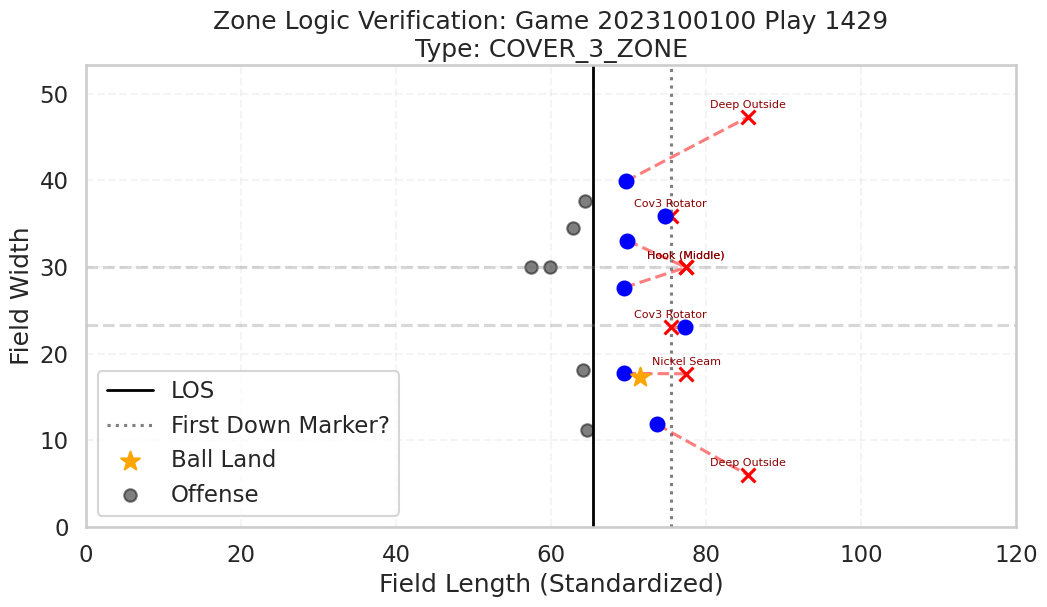

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- PART 1: LEAGUE TENDENCIES ---
print("--- COVERAGE DISTRIBUTION (What is the league playing?) ---")
cov_counts = df['team_coverage_type'].value_counts(normalize=True) * 100
print(cov_counts)

print("\n--- ZONE ASSIGNMENT DISTRIBUTION (League Wide) ---")
zone_counts = df['zone_assignment'].value_counts(normalize=True) * 100
print(zone_counts.head(10))

# --- PART 2: VISUALIZE A SINGLE PLAY ---
# Pick a random Cover 3 play to verify geometry
sample_play = df[df['team_coverage_type'] == 'COVER_3_ZONE'].sample(1).iloc[0]
game_id, play_id = sample_play['game_id'], sample_play['play_id']

# Get all data for this specific play (First frame of post_throw only)
play_df = df[(df['game_id'] == game_id) & 
             (df['play_id'] == play_id)].sort_values('frame_id').groupby('nfl_id').first().reset_index()

# Setup Plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f"Zone Logic Verification: Game {game_id} Play {play_id}\nType: {sample_play['team_coverage_type']}")
plt.xlabel("Field Length (Standardized)")
plt.ylabel("Field Width")

# Draw Field Boundaries
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.axvline(sample_play['los_x'], color='black', linewidth=2, label='LOS')
plt.axvline(sample_play['los_x'] + 10, color='gray', linestyle=':', label='First Down Marker?') # Approximation
# Draw Hash Marks (Roughly)
plt.axhline(23.366, color='gray', linestyle='--', alpha=0.3)
plt.axhline(29.966, color='gray', linestyle='--', alpha=0.3)

# Plot Ball Landing Spot
plt.scatter(sample_play['ball_land_x'], sample_play['ball_land_y'], 
            c='orange', s=200, marker='*', zorder=10, label='Ball Land')

# Plot Defenders & Their Zones
defenders = play_df[play_df['player_role'] == 'Defensive Coverage']

for _, player in defenders.iterrows():
    # 1. Plot Player Position
    ax.scatter(player['x'], player['y'], c='blue', s=100, zorder=5)
    
    # 2. Plot Assigned Zone Target
    if not pd.isna(player['target_zone_x']):
        ax.scatter(player['target_zone_x'], player['target_zone_y'], 
                   c='red', marker='x', s=100, zorder=4)
        
        # 3. Draw Connection Line (The "Leash")
        ax.plot([player['x'], player['target_zone_x']], 
                [player['y'], player['target_zone_y']], 
                color='red', linestyle='--', alpha=0.5)
        
        # 4. Label Zone Name
        ax.text(player['target_zone_x'], player['target_zone_y'] + 1, 
                player['zone_assignment'], fontsize=8, color='darkred', ha='center')

# Plot Offense (Just for context)
offense = play_df[play_df['player_side'] == 'Offense']
ax.scatter(offense['x'], offense['y'], c='black', alpha=0.5, label='Offense')

plt.legend(loc='lower left')
plt.grid(True, which='both', linestyle='--', alpha=0.2)
plt.show()

In [38]:
import pandas as pd
import numpy as np

def calculate_voids_production(df):
    """
    FINAL VOID DETECTOR (Decoupled & Strict)
    - Input: A dataframe that ALREADY has 'target_zone_x/y' (from Landmark Script).
    - Output: Void penalties and EPA damage.
    - Architecture: Pure pipeline step. Does not recalculate upstream data.
    """
    print(f"🚀 Starting Void Detection on {len(df)} frames...")
    
    required_cols = ['target_zone_x', 'target_zone_y', 'zone_assignment', 'ball_land_x']
    missing_cols = [c for c in required_cols if c not in df.columns]
    
    if missing_cols:
        raise ValueError(f"❌ CRITICAL ERROR: Missing upstream columns {missing_cols}. \n"
                         "Please run 'calculate_landmarks_final(df)' BEFORE running this script.")

    # Group by play and grab the LAST frame (The Catch/Incompletion)
    last_frames = df.sort_values('frame_id').groupby(['game_id', 'play_id']).tail(1).copy()
    
    # Filter for plays where ball_land data exists
    plays_with_ball = last_frames.dropna(subset=['ball_land_x', 'ball_land_y']).copy()
    
    if plays_with_ball.empty:
        print("⚠️ Warning: No plays found with valid ball landing coordinates.")
        return pd.DataFrame()

    # We assume 'df' already has the zone coordinates for every frame.
    # We just filter 'df' for defenders and merge with the specific 'end-of-play' frame IDs.
    relevant_frames = df[df['player_role'] == 'Defensive Coverage'].merge(
        plays_with_ball[['game_id', 'play_id', 'frame_id']],
        on=['game_id', 'play_id', 'frame_id'],
        how='inner'
    )

    # JURISDICTION (Who Owns This?)
    relevant_frames['dist_zone_to_ball'] = np.sqrt(
        (relevant_frames['target_zone_x'] - relevant_frames['ball_land_x'])**2 + 
        (relevant_frames['target_zone_y'] - relevant_frames['ball_land_y'])**2
    )
    
    # Find MIN distance per play
    relevant_frames['min_zone_dist'] = relevant_frames.groupby(['game_id', 'play_id'])['dist_zone_to_ball'].transform('min')
    
    # FILTER: SCHEME EXCEPTION (The 10-Yard Rule)
    relevant_frames = relevant_frames[relevant_frames['min_zone_dist'] < 10.0].copy()
    
    if relevant_frames.empty: return pd.DataFrame()

    # Assign Owner
    is_owner = relevant_frames['dist_zone_to_ball'] == relevant_frames['min_zone_dist']
    owners_df = relevant_frames[is_owner].copy()
    owners_df = owners_df.drop_duplicates(subset=['game_id', 'play_id'])

    # --- 5. THE AUDIT ---
    
    # Drift & Presence
    owners_df['drift_yards'] = np.sqrt(
        (owners_df['target_zone_x'] - owners_df['x'])**2 + 
        (owners_df['target_zone_y'] - owners_df['y'])**2
    )
    
    owners_df['dist_to_ball'] = np.sqrt(
        (owners_df['x'] - owners_df['ball_land_x'])**2 + 
        (owners_df['y'] - owners_df['ball_land_y'])**2
    )
    
    # Help Check
    teammates = relevant_frames[~relevant_frames['nfl_id'].isin(owners_df['nfl_id'])].copy()
    teammates['help_dist'] = np.sqrt(
        (teammates['x'] - teammates['ball_land_x'])**2 + 
        (teammates['y'] - teammates['ball_land_y'])**2
    )
    
    min_help = teammates.groupby(['game_id', 'play_id'])['help_dist'].min().reset_index()
    min_help.rename(columns={'help_dist': 'closest_help_dist'}, inplace=True)
    
    final_audit = owners_df.merge(min_help, on=['game_id', 'play_id'], how='left')
    final_audit['closest_help_dist'] = final_audit['closest_help_dist'].fillna(999)

    # --- 6. METRICS ---
    
    DRIFT_TOLERANCE = 5.0
    CATCH_RADIUS = 3.0
    HELP_RADIUS = 4.0 

    # Status Flags
    final_audit['void_penalty'] = (
        (final_audit['drift_yards'] > DRIFT_TOLERANCE) & 
        (final_audit['dist_to_ball'] > CATCH_RADIUS) & 
        (final_audit['closest_help_dist'] > HELP_RADIUS)
    )

    final_audit['bailed_out'] = (
        (final_audit['drift_yards'] > DRIFT_TOLERANCE) & 
        (final_audit['dist_to_ball'] > CATCH_RADIUS) & 
        (final_audit['closest_help_dist'] <= HELP_RADIUS)
    )
    
    # EPA Calculations
    final_audit['epa_lost'] = final_audit['expected_points_added']
    final_audit['damage_epa'] = final_audit['epa_lost'].apply(lambda x: x if x > 0 else 0)
    final_audit['is_punished'] = final_audit['damage_epa'] > 0

    cols = ['game_id', 'play_id', 'player_name', 'player_position', 'zone_assignment', 
            'drift_yards', 'dist_to_ball', 'closest_help_dist', 
            'void_penalty', 'bailed_out', 'is_punished',
            'epa_lost', 'damage_epa', 'pass_result']
    
    return final_audit[cols]

In [87]:
df_h = calculate_voids_production(df_)
diagnose_data_gaps(df_h, "Void Metrics df_h")

🚀 Starting Void Detection on 3419660 frames...

🕵️‍♀️ DATA FORENSICS: Void Metrics df_h
Total Rows: 5,289
✅ CLEAN. No missing values found in any column.


In [39]:
def prepare_forensic_data(df, game_id, play_id, victim_name):
    """
    PREPARES & REPAIRS DATA
    - Fixes 'Disappearing Players' by forward-filling positions.
    - Fixes 'Short Animation' by ensuring all frames exist.
    - Returns a clean dictionary for the visualizer.
    """
    # 1. Filter Raw Data
    raw_play = df[(df['game_id'] == game_id) & (df['play_id'] == play_id)].copy()
    if raw_play.empty: raise ValueError("Play not found.")

    # 2. DATA REPAIR: Forward Fill Missing Frames
    # Find the full range of frames (start to finish)
    min_f, max_f = raw_play['frame_id'].min(), raw_play['frame_id'].max()
    all_frames = range(min_f, max_f + 1)
    
    # Get all unique entities (Players + Football)
    # We use a composite key of (nfl_id, player_name) to keep metadata
    entities = raw_play[['nfl_id', 'player_name', 'player_role', 'player_position', 'team_coverage_man_zone']].drop_duplicates()
    
    # Create a "Skeleton" DataFrame (Every player x Every frame)
    # This ensures no one disappears even if data stops
    skeleton = pd.MultiIndex.from_product(
        [entities['nfl_id'], all_frames], 
        names=['nfl_id', 'frame_id']
    ).to_frame(index=False)
    
    # Merge Skeleton with Raw Data
    merged = skeleton.merge(raw_play, on=['nfl_id', 'frame_id'], how='left')
    
    # FORWARD FILL: Propagate last known location/attributes forward
    # Group by player so we don't fill Player A's data into Player B
    play_df = merged.groupby('nfl_id').ffill().bfill()
    
    # 3. Calculate Derived Metrics (LOS, Ghost) if missing
    if 'los_x' not in play_df.columns:
        snap = play_df[play_df['frame_id'] == min_f]
        qb = snap[snap['player_role'] == 'Passer']
        los = qb['x'].iloc[0] if not qb.empty else snap['x'].mean()
        play_df['los_x'] = los
        
    if 'target_zone_x' not in play_df.columns:
        # We only run logic on valid rows to save time
        play_df = calculate_landmarks_final(play_df)

    # 4. Extract Meta Data
    try: target = play_df[play_df['player_role'] == 'Targeted Receiver']['player_name'].iloc[0]
    except: target = "Unknown"
    
    try: qb = play_df[play_df['player_role'] == 'Passer']['player_name'].iloc[0]
    except: qb = "Unknown"
    
    # Victim Specifics
    vic_data = play_df[play_df['player_name'] == victim_name]
    if vic_data.empty: raise ValueError(f"{victim_name} not in play.")
    
    ghost = {
        'x': vic_data['target_zone_x'].median(),
        'y': vic_data['target_zone_y'].median(),
        'label': vic_data['zone_assignment'].iloc[0] if 'zone_assignment' in vic_data else "Unknown"
    }
    
    field = {
        'los': play_df['los_x'].iloc[0],
        'ball_land': (play_df['ball_land_x'].iloc[0], play_df['ball_land_y'].iloc[0])
    }

    return {
        'df': play_df,
        'meta': {'names': {'victim': victim_name, 'target': target, 'qb': qb},
                 'ghost': ghost,
                 'field': field}
    }

def animate_forensic_data(context):
    """
    PURE VISUALIZER
    - Accepts pre-processed 'context' dictionary.
    - No data logic, only plotting logic.
    """
    df = context['df']
    names = context['meta']['names']
    ghost = context['meta']['ghost']
    field = context['meta']['field']
    
    # Plot Setup
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 120); ax.set_ylim(0, 53.3)
    ax.set_facecolor('forestgreen')
    ax.grid(axis='x', c='w', alpha=0.5, ls='--')
    ax.axhline(23.366, c='w', alpha=0.3, ls=':'); ax.axhline(29.966, c='w', alpha=0.3, ls=':')
    
    # Static Markers
    ax.axvline(field['los'], c='blue', alpha=0.5, label='LOS')
    
    ghost_box = Rectangle((ghost['x']-5, ghost['y']-5), 10, 10, fc='yellow', alpha=0.25, ec='yellow', ls='--', zorder=2)
    ax.add_patch(ghost_box)
    ax.text(ghost['x'], ghost['y'], f"EMPTY\n{ghost['label']}", c='yellow', fontsize=7, ha='center', va='center', fontweight='bold')
    
    if not np.isnan(field['ball_land'][0]):
        ax.scatter(field['ball_land'][0], field['ball_land'][1], c='magenta', s=150, marker='X', ec='white', zorder=8)

    # Scatters
    scat_vic = ax.scatter([], [], c='red', s=150, marker='s', ec='black', zorder=10)
    scat_tar = ax.scatter([], [], c='gold', s=180, marker='*', ec='black', zorder=10)
    scat_qb  = ax.scatter([], [], c='cyan', s=120, marker='D', ec='black', zorder=9)
    scat_def = ax.scatter([], [], c='dodgerblue', s=80, ec='white', zorder=5)
    scat_off = ax.scatter([], [], c='orange', s=70, alpha=0.7, ec='white', zorder=4)
    drift_line, = ax.plot([], [], c='red', ls=':', lw=2, zorder=6)
    
    texts = [ax.text(0,0, "", fontsize=8, ha='center', path_effects=[pe.withStroke(linewidth=2, foreground='black')]) for _ in range(22)]
    time_text = ax.text(2, 2, '', c='white', fontsize=10, fontweight='bold')

    # Legend
    legend = [
        Line2D([0], [0], marker='s', c='w', mfc='red', label=f"VOID: {names['victim']}"),
        Line2D([0], [0], marker='*', c='w', mfc='gold', label=f"Target: {names['target']}"),
        Line2D([0], [0], marker='D', c='w', mfc='cyan', label='QB'),
        Line2D([0], [0], marker='X', c='w', mfc='magenta', label='Ball Land'),
        Line2D([0], [0], marker='o', c='w', mfc='dodgerblue', label='Defense'),
        Rectangle((0,0), 1, 1, fc='yellow', alpha=0.5, label='Ghost Zone')
    ]
    ax.legend(handles=legend, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, facecolor='black', labelcolor='white')

    # Update Loop
    frames = sorted(df['frame_id'].unique())
    
    def update(frame):
        d = df[df['frame_id'] == frame]
        
        vic = d[d['player_name'] == names['victim']]
        tar = d[d['player_name'] == names['target']]
        qb = d[d['player_name'] == names['qb']]
        
        team_def = d[(d['player_role'] == 'Defensive Coverage') & (d['player_name'] != names['victim'])]
        team_off = d[(d['player_role'] != 'Defensive Coverage') & (~d['player_name'].isin([names['target'], names['qb']]))]

        # Update Offsets
        scat_vic.set_offsets(vic[['x','y']].values if not vic.empty else np.empty((0,2)))
        scat_tar.set_offsets(tar[['x','y']].values if not tar.empty else np.empty((0,2)))
        scat_qb.set_offsets(qb[['x','y']].values if not qb.empty else np.empty((0,2)))
        scat_def.set_offsets(team_def[['x','y']].values if not team_def.empty else np.empty((0,2)))
        scat_off.set_offsets(team_off[['x','y']].values if not team_off.empty else np.empty((0,2)))
        
        if not vic.empty:
            drift_line.set_data([vic['x'].values[0], ghost['x']], [vic['y'].values[0], ghost['y']])

        # Update Text
        labeled = pd.concat([vic, tar, qb, team_def])
        for i, txt in enumerate(texts):
            if i < len(labeled):
                p = labeled.iloc[i]
                txt.set_position((p['x'], p['y']+1.5))
                
                dist = np.sqrt((p['x']-ghost['x'])**2 + (p['y']-ghost['y'])**2)
                
                if p['player_name'] == names['victim']:
                    txt.set_text(p['player_name']); txt.set_color('salmon'); txt.set_fontsize(10)
                elif p['player_name'] == names['target']:
                    txt.set_text(p['player_name']); txt.set_color('gold'); txt.set_fontsize(9)
                elif p['player_name'] == names['qb']:
                    txt.set_text("QB"); txt.set_color('cyan'); txt.set_fontsize(8)
                elif dist < 15 and p['player_name'] not in [names['target'], names['qb']]:
                    # Savers
                    txt.set_text(f"{p['player_name']}\n({dist:.1f}y)")
                    txt.set_color('white'); txt.set_fontsize(8); txt.set_fontweight('bold')
                else:
                    txt.set_text("")
            else:
                txt.set_text("")
                
        time_text.set_text(f"Frame: {frame}")
        return scat_vic, scat_tar, scat_qb, scat_def, scat_off, drift_line, time_text, *texts

    print(f"🎬 Rendering Forensic Animation for {names['victim']}...")
    ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

In [40]:
if 'df' in locals():
    # 1. Run Pipeline
    processed_sample = calculate_landmarks_final(df)
    
    # Run Vectorized Logic
    target_voids = calculate_voids_production(processed_sample)

🚀 Starting Void Detection on 3419660 frames...


In [41]:
target_voids.head(5)

game_id  play_id    player_name player_position zone_assignment  \
0  2023090700      219  Alex Anzalone             OLB       Curl/Flat   
1  2023090700      530     Leo Chenal             OLB       Curl/Flat   
2  2023090700      713  Alex Anzalone             OLB       Curl/Flat   
3  2023090700      877  Jack Campbell             MLB       Curl/Flat   
4  2023090700     1069    Nick Bolton             MLB   Hook (Middle)   

   drift_yards  dist_to_ball  closest_help_dist  void_penalty  bailed_out  \
0     3.056551      5.049831              999.0         False       False   
1     5.772921      2.317086              999.0         False       False   
2     5.689575      1.606553              999.0         False       False   
3     2.551546      8.234225              999.0         False       False   
4     2.292757      7.156816              999.0         False       False   

   is_punished  epa_lost  damage_epa pass_result  
0         True  0.089352    0.089352           C  
1         True  0.031384    0.031384           C  
2        False -0.873874    0.000000           I  
3         True  1.140134    1.140134           C  
4         True  0.566854    0.566854           C

In [42]:
# --- EXECUTION ---
if 'processed_sample' in locals() and 'target_voids' in locals():
    # 2. Add Damage Logic (Critical Step for new Leaderboard)
    if not target_voids.empty:
        # Create helper columns for the aggregation
        target_voids['damage_epa'] = target_voids['epa_lost'].apply(lambda x: x if x > 0 else 0)
        target_voids['is_punished'] = target_voids['epa_lost'] > 0

        # 3. Create Leaderboard
        leaderboard = target_voids.groupby(['player_name', 'player_position']).agg(
            total_drifts=('game_id', 'count'),          
            punished_count=('is_punished', 'sum'),      
            total_damage_epa=('damage_epa', 'sum'),     
            net_epa=('epa_lost', 'sum')                 
        ).reset_index() # <--- FIX: This moves victim_name back to a column!
        
        # Sort
        leaderboard = leaderboard.sort_values('total_damage_epa', ascending=False)

        # 4. Select Worst Defender
        worst_defender = leaderboard.iloc[10]
        player_name = worst_defender['player_name']
        
        print(f"\n📉 IDENTIFIED LIABILITY: {player_name}")
        print(f"   Position: {worst_defender['player_position']}")
        print(f"   Total Damage: {worst_defender['total_damage_epa']:.2f} EPA")
        print("-" * 40)

        # 5. Get Raw Data for Animation
        player_voids = target_voids[target_voids['player_name'] == player_name].copy()
        player_voids_sorted = player_voids.sort_values('epa_lost', ascending=False)
        # print(player_voids_sorted.head(16))
        
        # Select worst play
        worst_play = player_voids_sorted.iloc[0]
        
        target_game_id = worst_play['game_id']
        target_play_id = worst_play['play_id']
        pass_result = worst_play['pass_result']

        print(f"🎯 AUTOMATICALLY SELECTED WORST MOMENT:")
        print(f"   Game ID: {target_game_id}")
        print(f"   Play ID: {target_play_id}")
        print(f"   Outcome: {pass_result}")
        print(f"   EPA Lost: {worst_play['epa_lost']:.4f}")
        
    else:
        print("No voids found.")


📉 IDENTIFIED LIABILITY: Bobby Wagner
   Position: MLB
   Total Damage: 32.07 EPA
----------------------------------------
🎯 AUTOMATICALLY SELECTED WORST MOMENT:
   Game ID: 2023092409
   Play ID: 4968
   Outcome: C
   EPA Lost: 2.4588


In [35]:
anim_context = prepare_forensic_data(df, target_game_id, target_play_id, player_name)
display(animate_forensic_data(anim_context))

🎬 Rendering Forensic Animation for Bobby Wagner...


🧪 Starting Metric Validation...

--- STABILITY CHECK ---
Players Analyzed: 63
Correlation (r): 0.558 (Values > 0.3 are good for defense, > 0.5 are excellent)
P-Value: 0.0000

--- GENERATING PLAYER ARCHETYPES ---
                                  snaps  void_count  total_epa_lost  \
player_name      player_position                                      
T.J. Edwards     OLB                325        27.0       14.550525   
Camryn Bynum     FS                 313         1.0        3.951703   
Darious Williams CB                 306         5.0        3.569286   

                                  void_rate  avg_damage_per_void  
player_name      player_position                                  
T.J. Edwards     OLB               8.307692             0.538908  
Camryn Bynum     FS                0.319489             3.951703  
Darious Williams CB                1.633987             0.713857  


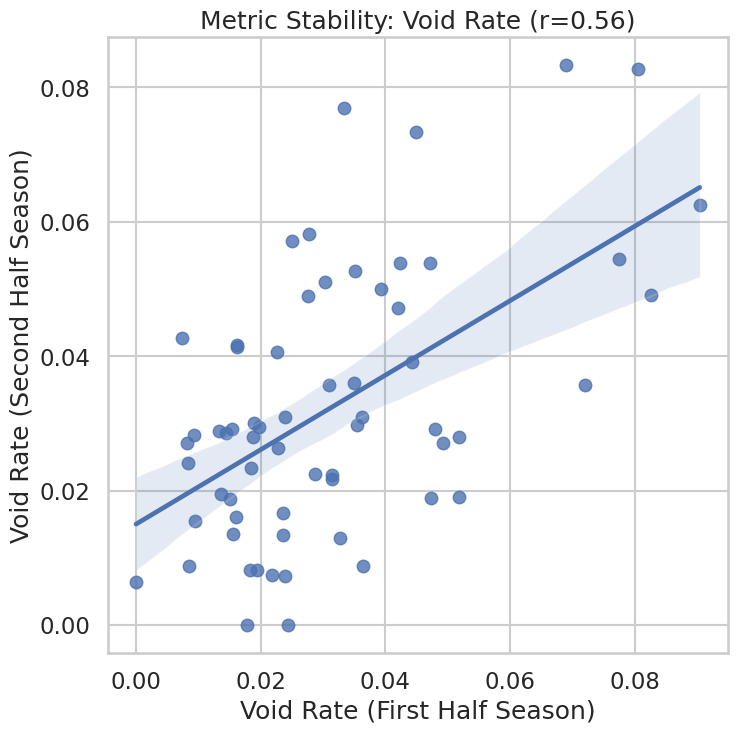

In [37]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

def validate_and_aggregate(void_df, full_df):
    print("🧪 Starting Metric Validation...")

    # --- 1. PREPARE DATA ---
    # We need the week number for stability checks
    # Extract week from game_id (First 4 digits = Year, next 2 = Month... usually easier to just map)
    # Approximation: Sort game_ids, split into First Half / Second Half of season
    unique_games = sorted(void_df['game_id'].unique())
    midpoint = len(unique_games) // 2
    early_games = unique_games[:midpoint]
    late_games = unique_games[midpoint:]

    # --- 2. STABILITY TEST (Split-Half Reliability) ---
    def get_player_stats(games_list):
        # Filter for these games
        subset = void_df[void_df['game_id'].isin(games_list)]
        
        # Count Voids
        voids = subset[subset['void_penalty']].groupby('player_name').size()
        
        # Count Snaps (Approximate by unique plays in full_df)
        # Note: Ideally you pass the snap_counts dataframe calculated earlier
        snaps = full_df[
            (full_df['game_id'].isin(games_list)) & 
            (full_df['player_role'] == 'Defensive Coverage')
        ].groupby('player_name')['play_id'].nunique()
        
        stats_df = pd.DataFrame({'voids': voids, 'snaps': snaps}).fillna(0)
        # Filter for minimum volume (e.g., 100 snaps) to avoid noise
        stats_df = stats_df[stats_df['snaps'] > 100]
        stats_df['void_rate'] = stats_df['voids'] / stats_df['snaps']
        return stats_df['void_rate']

    rate_early = get_player_stats(early_games)
    rate_late = get_player_stats(late_games)

    # Merge and correlate
    stability = pd.concat([rate_early, rate_late], axis=1, keys=['Early', 'Late']).dropna()
    r_value, p_value = stats.pearsonr(stability['Early'], stability['Late'])

    print(f"\n--- STABILITY CHECK ---")
    print(f"Players Analyzed: {len(stability)}")
    print(f"Correlation (r): {r_value:.3f} (Values > 0.3 are good for defense, > 0.5 are excellent)")
    print(f"P-Value: {p_value:.4f}")

    # --- 3. ARCHETYPE AGGREGATION ---
    print("\n--- GENERATING PLAYER ARCHETYPES ---")
    # Total Season Stats
    total_voids = void_df[void_df['void_penalty']].groupby('player_name')['damage_epa'].agg(['count', 'sum'])
    total_voids.columns = ['void_count', 'total_epa_lost']
    
    # Get total snaps for rate
    total_snaps = full_df[full_df['player_role'] == 'Defensive Coverage'].groupby(['player_name', 'player_position'])['play_id'].nunique()
    
    archetypes = pd.DataFrame(total_snaps).merge(total_voids, left_index=True, right_index=True, how='left').fillna(0)
    archetypes.rename(columns={'play_id': 'snaps'}, inplace=True)
    
    # Filter for qualified players (e.g., 300+ snaps)
    archetypes = archetypes[archetypes['snaps'] > 300].copy()
    
    # Calculate Metrics
    archetypes['void_rate'] = (archetypes['void_count'] / archetypes['snaps']) * 100
    archetypes['avg_damage_per_void'] = archetypes['total_epa_lost'] / archetypes['void_count']
    
    # Sort by "Most Dangerous Liabilities" (High Rate + High Damage)
    print(archetypes.sort_values('total_epa_lost', ascending=False).head(10))
    
    return stability, archetypes

# --- EXECUTION ---
# Requires: 'void_results' (from void script) and 'df' (original data)
stability_data, player_ranks = validate_and_aggregate(void_results, df)

# --- PLOT STABILITY (Visual Proof) ---
plt.figure(figsize=(8, 8))
sns.regplot(x='Early', y='Late', data=stability_data)
plt.title(f"Metric Stability: Void Rate (r={stability_data.corr().iloc[0,1]:.2f})")
plt.xlabel("Void Rate (First Half Season)")
plt.ylabel("Void Rate (Second Half Season)")
plt.show()

In [21]:
# --- 1. THE REPUTATION CHECK (Who are the worst offenders?) ---
print("--- MOST FREQUENT OFFENDERS (Count of Voids) ---")
void_results = target_voids
# We look for players who are constantly out of position
void_counts = void_results[void_results['void_penalty']].groupby(['player_name', 'player_position']).size().reset_index(name='void_count')
print(void_counts.sort_values('void_count', ascending=False).head(10))

print("\n--- MOST DAMAGING OFFENDERS (Total EPA Lost) ---")
# We look for players who gave up BIG plays (TDs, long gains)
# We filter for 'is_punished' because we only care if the offense capitalized
damage_counts = void_results[void_results['is_punished']].groupby(['player_name', 'player_position'])['damage_epa'].sum().reset_index()
print(damage_counts.sort_values('damage_epa', ascending=False).head(10))

# --- 2. THE POSITIONAL REALITY CHECK ---
print("\n--- VOIDS BY POSITION (Expect LBs to be highest) ---")
# Linebackers have the hardest zones (middle of field) and drift the most.
# Corners should be lower. Safeties should be lowest (last line of defense).
print(void_results[void_results['void_penalty']]['player_position'].value_counts())

# --- 3. THE "NEAR MISS" CHECK ---
print("\n--- LUCKY DEFENDERS (Bailed Out by Teammates) ---")
# Who abandons their zone but gets saved by a Safety?
bailed_out = void_results[void_results['bailed_out']].groupby(['player_name', 'player_position']).size().reset_index(name='saved_count')
print(bailed_out.sort_values('saved_count', ascending=False).head(5))

# --- 4. FIND A "PERFECT STORM" PLAY FOR VISUALIZATION ---
# Find a play with High Drift (> 10 yards) and High EPA Lost (> 2.0)
worst_play = void_results[
    (void_results['void_penalty']) & 
    (void_results['drift_yards'] > 10) & 
    (void_results['damage_epa'] > 1.5)
].sort_values('damage_epa', ascending=False).head(1)

print("\n--- CANDIDATE FOR VISUALIZATION (Copy these IDs) ---")
print(worst_play[['game_id', 'play_id', 'player_name', 'drift_yards', 'damage_epa']])

--- MOST FREQUENT OFFENDERS (Count of Voids) ---
             player_name player_position  void_count
374         T.J. Edwards             OLB          27
263       Kenny Moore II              CB          24
160         Foye Oluokun             OLB          21
40          Bobby Wagner             MLB          18
262  Kenneth Murray, Jr.             MLB          17
118        Demario Davis             MLB          16
278        Lavonte David             ILB          15
139         Dre Greenlaw             ILB          14
162          Fred Warner             MLB          13
231        Jordyn Brooks             ILB          13

--- MOST DAMAGING OFFENDERS (Total EPA Lost) ---
             player_name player_position  damage_epa
459       Zaire Franklin             MLB   40.063924
283       Kenny Moore II              CB   38.009134
58           C.J. Mosley             ILB   37.995331
303         Logan Wilson             MLB   37.932805
384      Robert Spillane             ILB   36.652991


running depth analysis...


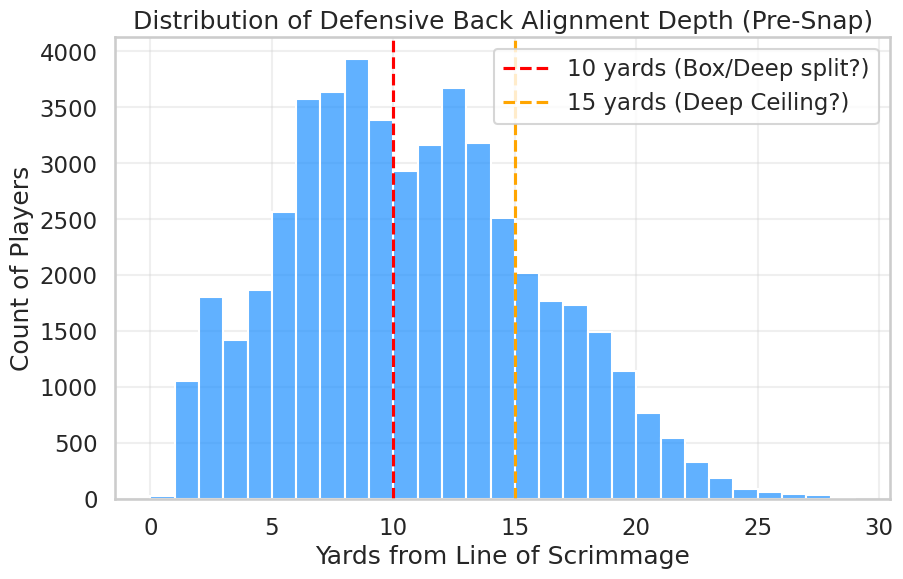

Depth Statistics:
 count    49070.000000
mean        10.830285
std          5.154832
min          0.000000
25%          6.980000
50%         10.425000
75%         14.210000
max         52.750000
Name: depth, dtype: float64


In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def find_optimal_depth_threshold(df):
    """
    FIXED: Calculates Line of Scrimmage (LOS) manually to determine 
    accurate DB depths.
    """
    print("running depth analysis...")
    
    # 1. Isolate Frame 1 (The Snap)
    snap_data = df[df['frame_id'] == 1].copy()
    
    # 2. Calculate LOS per Play (The "Meeting Point" of Offense/Defense)
    # We group by game+play to handle each snap individually
    los_map = {}
    
    for (g_id, p_id), play_group in snap_data.groupby(['game_id', 'play_id']):
        # Determine direction
        direction = play_group['play_direction'].iloc[0]
        
        # Get Offense and Defense X coordinates
        off_x = play_group[play_group['player_side'] == 'Offense']['x']
        def_x = play_group[play_group['player_side'] == 'Defense']['x']
        
        if off_x.empty or def_x.empty:
            continue # Skip bad data
            
        if direction == 'right':
            # Moving Right -> Offense is Left (Low X), Defense is Right (High X)
            # LOS is the front of the Offense
            current_los = off_x.max()
        else:
            # Moving Left -> Offense is Right (High X), Defense is Left (Low X)
            # LOS is the front of the Offense
            current_los = off_x.min()
            
        los_map[(g_id, p_id)] = current_los

    # 3. Map LOS back to the dataframe
    # Create a MultiIndex for mapping
    snap_data['los_x_calc'] = snap_data.set_index(['game_id', 'play_id']).index.map(los_map)
    
    # 4. Filter for DBs only (Cornerbacks & Safeties) to measure THEIR depth
    dbs_only = snap_data[snap_data['player_position'].isin(['CB', 'S', 'SS', 'FS', 'DB'])].copy()
    
    # 5. Calculate Depth (Absolute distance from LOS)
    dbs_only['depth'] = (dbs_only['x'] - dbs_only['los_x_calc']).abs()
    
    # Drop NaNs (plays where LOS calc failed)
    dbs_only = dbs_only.dropna(subset=['depth'])
    
    # 6. Plot Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(dbs_only['depth'], bins=range(0, 30, 1), color='dodgerblue', alpha=0.7)
    
    # Add potential threshold lines
    plt.axvline(10, color='red', linestyle='--', label='10 yards (Box/Deep split?)')
    plt.axvline(15, color='orange', linestyle='--', label='15 yards (Deep Ceiling?)')
    
    plt.title("Distribution of Defensive Back Alignment Depth (Pre-Snap)")
    plt.xlabel("Yards from Line of Scrimmage")
    plt.ylabel("Count of Players")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return dbs_only['depth'].describe()

# --- EXECUTION ---
if 'df' in locals():
    stats = find_optimal_depth_threshold(df)
    print("Depth Statistics:\n", stats)

In [3]:
# 1. SNAPSHOT: Get State at Throw (t=0)
# We filter for the specific frame where the manipulation 'outcome' is locked in
t_throw = df[df['event'] == 'pass_forward'].copy()
if t_throw.empty:
    # Fallback: Last frame of pre_throw if event tag is missing
    t_throw = df[df['phase'] == 'pre_throw'].sort_values('frame_id').groupby(['game_id', 'play_id']).tail(1)

# 2. ISOLATE ACTORS
# Target Location
targets = t_throw[t_throw['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'x', 'y']]
targets = targets.rename(columns={'x': 't_x', 'y': 't_y'})

# Defenders (Coverage Only)
defenders = t_throw[t_throw['player_role'] == 'Defensive Coverage'].copy()

# Merge
analysis = defenders.merge(targets, on=['game_id', 'play_id'], how='inner')

# 3. VECTOR MATH (The Truth Engine)

# A. Movement Vector
# Convert NFL Dir (0=N, 90=E) to Radians
analysis['dir_rad'] = np.radians(90 - analysis['dir'])
analysis['move_x'] = analysis['s'] * np.cos(analysis['dir_rad'])
analysis['move_y'] = analysis['s'] * np.sin(analysis['dir_rad'])

# B. Orientation Vector
analysis['o_rad'] = np.radians(90 - analysis['o'])
analysis['face_x'] = np.cos(analysis['o_rad'])
analysis['face_y'] = np.sin(analysis['o_rad'])

# C. Target Vector (Defender -> Target)
analysis['vec_x'] = analysis['t_x'] - analysis['x']
analysis['vec_y'] = analysis['t_y'] - analysis['y']

# Normalize Target Vector (Unit Vector)
mag = np.sqrt(analysis['vec_x']**2 + analysis['vec_y']**2)
analysis['target_ux'] = analysis['vec_x'] / (mag + 1e-9)
analysis['target_uy'] = analysis['vec_y'] / (mag + 1e-9)

# 4. ALIGNMENT SCORES
# Score 1: Movement Alignment (Are you moving towards target?)
move_mag = np.sqrt(analysis['move_x']**2 + analysis['move_y']**2)
analysis['align_move_target'] = ((analysis['move_x']/(move_mag+1e-9)) * analysis['target_ux']) + \
                                ((analysis['move_y']/(move_mag+1e-9)) * analysis['target_uy'])

# Score 2: Hips Alignment (Are you facing your movement?)
analysis['align_face_move'] = (analysis['face_x'] * (analysis['move_x']/(move_mag+1e-9))) + \
                              (analysis['face_y'] * (analysis['move_y']/(move_mag+1e-9)))

# 5. OUTCOME TAGS
analysis['is_complete'] = analysis['pass_result'].apply(lambda x: 1 if x == 'C' else 0)

print("Vector Analysis Complete. Ready for testing.")

Loaded 3991681 rows.
Vector Analysis Complete. Ready for testing.


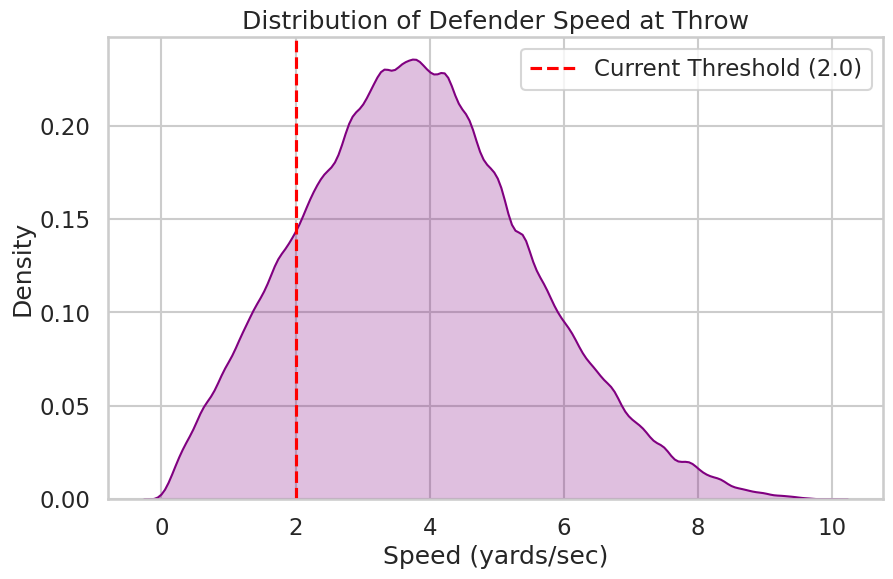

INTERPRETATION:
- Peak 1 (Left): Defenders shuffling/reading.
- Peak 2 (Right): Defenders reacting/sprinting.
- VALIDATION: The red line should sit in the 'Valley' between these peaks.


In [4]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=analysis, x='s', fill=True, color='purple', bw_adjust=0.5)
plt.axvline(2.0, color='red', linestyle='--', label='Current Threshold (2.0)')

plt.title("Distribution of Defender Speed at Throw")
plt.xlabel("Speed (yards/sec)")
plt.ylabel("Density")
plt.legend()
plt.show()

print("INTERPRETATION:")
print("- Peak 1 (Left): Defenders shuffling/reading.")
print("- Peak 2 (Right): Defenders reacting/sprinting.")
print("- VALIDATION: The red line should sit in the 'Valley' between these peaks.")

/tmp/ipykernel_88305/3400301282.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  epa_curve = analysis.groupby('align_bin')['expected_points_added'].mean().reset_index()


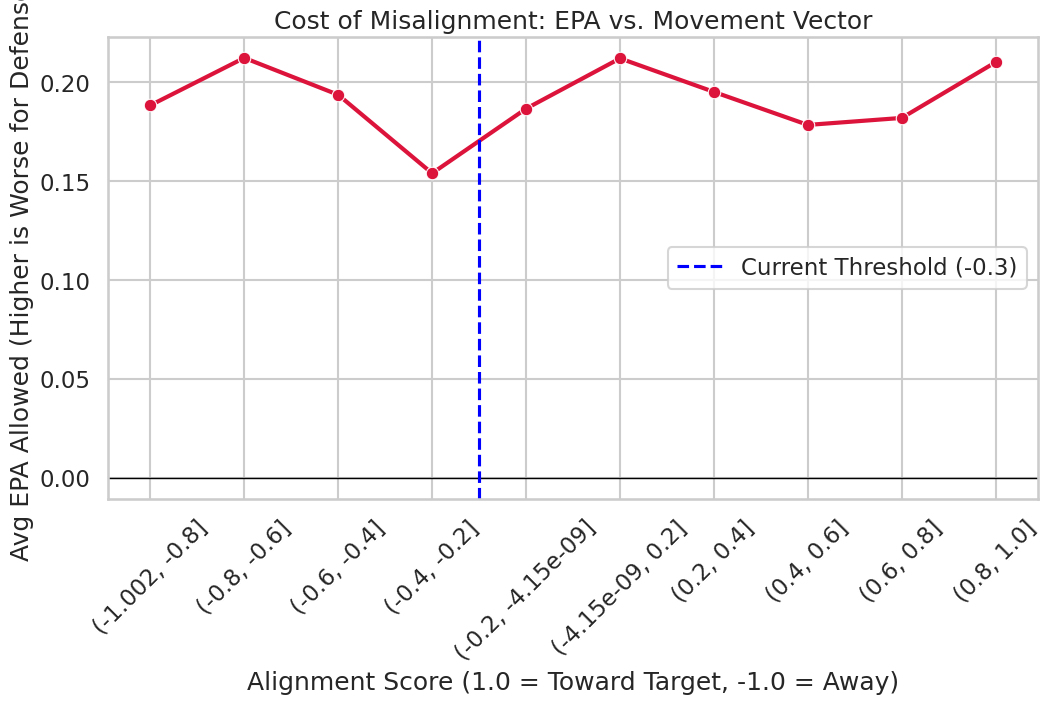

INTERPRETATION:
- Left Side (Negative): Moving away from target.
- Right Side (Positive): Moving towards target.
- VALIDATION: EPA should rise sharply to the left of the blue line.


In [5]:
# Bin the alignment score
analysis['align_bin'] = pd.cut(analysis['align_move_target'], bins=10)

# Calculate Mean EPA per bin
epa_curve = analysis.groupby('align_bin')['expected_points_added'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=epa_curve, x=epa_curve.index, y='expected_points_added', marker='o', linewidth=3, color='crimson')

# Draw the bins as X-ticks
plt.xticks(epa_curve.index, epa_curve['align_bin'].astype(str), rotation=45)
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axvline(3.5, color='blue', linestyle='--', label='Current Threshold (-0.3)')

plt.title("Cost of Misalignment: EPA vs. Movement Vector")
plt.ylabel("Avg EPA Allowed (Higher is Worse for Defense)")
plt.xlabel("Alignment Score (1.0 = Toward Target, -1.0 = Away)")
plt.legend()
plt.show()

print("INTERPRETATION:")
print("- Left Side (Negative): Moving away from target.")
print("- Right Side (Positive): Moving towards target.")
print("- VALIDATION: EPA should rise sharply to the left of the blue line.")

/tmp/ipykernel_88305/2679353419.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=wrong_way, x='posture', y='is_complete', palette=['red', 'orange'])


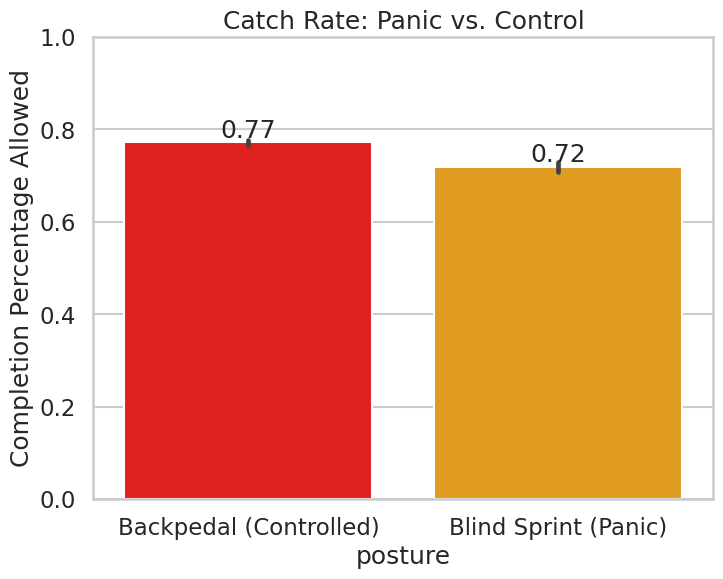

INTERPRETATION:
- If 'Blind Sprint' has a higher bar than 'Backpedal', your logic is VALID.
- This proves that orientation (hips) is the difference between a zone drop and a blown coverage.


In [6]:
# Filter for defenders moving the WRONG way (Alignment < -0.3)
wrong_way = analysis[analysis['align_move_target'] < -0.3].copy()

# Classify by Orientation
# High Score (> 0.5) = Facing Forward (Running Blind)
# Low Score (< 0.5) = Facing Backward (Backpedaling/Strafe)
wrong_way['posture'] = wrong_way['align_face_move'].apply(
    lambda x: 'Blind Sprint (Panic)' if x > 0.5 else 'Backpedal (Controlled)'
)

# Compare Catch Rates
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=wrong_way, x='posture', y='is_complete', palette=['red', 'orange'])
plt.title("Catch Rate: Panic vs. Control")
plt.ylabel("Completion Percentage Allowed")
plt.ylim(0, 1.0)

# Add Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.show()

print("INTERPRETATION:")
print("- If 'Blind Sprint' has a higher bar than 'Backpedal', your logic is VALID.")
print("- This proves that orientation (hips) is the difference between a zone drop and a blown coverage.")

In [8]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os

# --- CONFIG ---
TRUTH_TABLE_FILE = '../data/processed/truth_table_check.csv'
TRACKING_FILE = '../data/processed/master_zone_tracking.csv'
OUTPUT_DIR = '../data/reports/audit_clips'

def load_data():
    if not os.path.exists(TRUTH_TABLE_FILE) or not os.path.exists(TRACKING_FILE):
        print("❌ Missing input files. Run create_truth_table.py first.")
        return None, None
    
    tt = pd.read_csv(TRUTH_TABLE_FILE)
    tracking = pd.read_csv(TRACKING_FILE, low_memory=False)
    return tt, tracking

def get_audit_samples(tt_df):
    """Selects 3 representative plays from each Verdict category."""
    samples = []
    
    # Categories to audit
    categories = [
        "✅ GOOD: Covering", 
        "❌ BAD: Drifting", 
        "☠️ TERRIBLE: Full Bite"
    ]
    
    for cat in categories:
        # Get random sample or top confidence sample
        # We pick the most extreme examples (highest speed for Terrible, best alignment for Good)
        subset = tt_df[tt_df['Verdict'] == cat]
        
        if cat == "✅ GOOD: Covering":
            picks = subset.nlargest(3, 'align_move_target') # Best alignment
        elif cat == "☠️ TERRIBLE: Full Bite":
            picks = subset.nsmallest(3, 'align_move_target') # Worst alignment
        else:
            picks = subset.sample(min(3, len(subset)), random_state=42)
            
        for _, row in picks.iterrows():
            samples.append(row)
            
    return pd.DataFrame(samples)

def create_animation(play_track, verdict, player_name, game_id, play_id):
    """Generates a simple field animation for the audit."""
    
    # 1. Setup Visuals
    play_track['color'] = 'Other'
    play_track['size_val'] = 8 # Default size
    
    # Set Specific Colors & Sizes
    # Audit Target (Magenta, Large)
    mask_target = play_track['player_name'] == player_name
    play_track.loc[mask_target, 'color'] = 'AUDIT TARGET'
    play_track.loc[mask_target, 'size_val'] = 18 
    
    # Receiver (Lime, Medium)
    mask_rec = play_track['player_role'] == 'Targeted Receiver'
    play_track.loc[mask_rec, 'color'] = 'TARGET'
    play_track.loc[mask_rec, 'size_val'] = 14
    
    # Ball (Brown, Small)
    # Note: 'football' might not have player_role, check nfl_id or name
    # Usually displayName is 'football'
    mask_ball = play_track['player_name'] == 'football'
    play_track.loc[mask_ball, 'color'] = 'BALL'
    play_track.loc[mask_ball, 'size_val'] = 10
    
    color_map = {
        'AUDIT TARGET': 'magenta', 
        'TARGET': 'lime',          
        'BALL': 'brown',
        'Other': 'lightgray'
    }
    
    # 2. Plot
    fig = px.scatter(
        play_track, x='x', y='y', animation_frame='frame_id', animation_group='nfl_id',
        color='color', color_discrete_map=color_map,
        size='size_val', size_max=18, # Use the numeric column here
        range_x=[0, 120], range_y=[0, 53.3],
        title=f"AUDIT: {verdict} | {player_name} (G:{game_id} P:{play_id})"
    )
    
    # Add Field markings (Simple)
    fig.add_shape(type="rect", x0=0, y0=0, x1=120, y1=53.3, line=dict(color="green"), fillcolor="green", opacity=0.1, layer="below")
    
    for x in range(10, 111, 10):
        fig.add_shape(type="line", x0=x, y0=0, x1=x, y1=53.3, line=dict(color="white", width=1), layer="below")

    return fig

def run_audit():
    tt, tracking = load_data()
    if tt is None: return

    print("Selecting Audit Samples...")
    samples = get_audit_samples(tt)
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for i, row in samples.iterrows():
        gid, pid, name, verdict = row['game_id'], row['play_id'], row['player_name'], row['Verdict']
        
        print(f"Generating clip for: {name} ({verdict})...")
        
        # Extract play data
        # Get +/- 20 frames around the throw for context
        play_data = tracking[(tracking['game_id'] == gid) & (tracking['play_id'] == pid)].copy()
        
        # Find throw frame
        throw_frame = play_data[play_data['event'] == 'pass_forward']['frame_id'].min()
        if pd.isna(throw_frame):
             throw_frame = play_data[play_data['phase'] == 'pre_throw']['frame_id'].max()
        
        start = max(1, throw_frame - 20)
        end = throw_frame + 20
        clip = play_data[(play_data['frame_id'] >= start) & (play_data['frame_id'] <= end)]
        
        # Create and Save
        fig = create_animation(clip, verdict, name, gid, pid)
        
        filename = f"{OUTPUT_DIR}/{verdict.split(':')[0].strip()}_{name.replace(' ', '_')}_{pid}.html"
        fig.write_html(filename)
        print(f"   -> Saved to {filename}")

    print(f"\n✅ Audit Complete. Open the HTML files in '{OUTPUT_DIR}' to verify your logic.")

if __name__ == '__main__':
    run_audit()

Selecting Audit Samples...
Generating clip for: Devin White (✅ GOOD: Covering)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_track['color'] = 'Other'
/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_track['size_val'] = 8 # Default size


   -> Saved to ../data/reports/audit_clips/✅ GOOD_Devin_White_2587.html
Generating clip for: Lavonte David (✅ GOOD: Covering)...
   -> Saved to ../data/reports/audit_clips/✅ GOOD_Lavonte_David_3130.html
Generating clip for: Charvarius Ward (✅ GOOD: Covering)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/✅ GOOD_Charvarius_Ward_823.html
Generating clip for: Denzel Ward (❌ BAD: Drifting)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/❌ BAD_Denzel_Ward_1101.html
Generating clip for: Chidobe Awuzie (❌ BAD: Drifting)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/❌ BAD_Chidobe_Awuzie_3427.html
Generating clip for: Terrel Bernard (❌ BAD: Drifting)...
   -> Saved to ../data/reports/audit_clips/❌ BAD_Terrel_Bernard_3865.html
Generating clip for: Jevon Holland (☠️ TERRIBLE: Full Bite)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/☠️ TERRIBLE_Jevon_Holland_328.html
Generating clip for: Jayron Kearse (☠️ TERRIBLE: Full Bite)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/☠️ TERRIBLE_Jayron_Kearse_1685.html
Generating clip for: Jayron Kearse (☠️ TERRIBLE: Full Bite)...


/tmp/ipykernel_88305/1050230667.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_88305/1050230667.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   -> Saved to ../data/reports/audit_clips/☠️ TERRIBLE_Jayron_Kearse_374.html

✅ Audit Complete. Open the HTML files in '../data/reports/audit_clips' to verify your logic.
